<h1>Analisi del trasporto ferroviario italiano</h1>
<h3>Spolaor Andrea</h3>

<h2>FASE 1:</h2>

<h3>Inizializzazione</h3>

<p>Importo tutte le librerie necessarie e aggiorno le envirorment variable presenti nel progetto.</p>

<p>E' stata creata la funzione <b>geocode_station</b> dove viene identificata la posizione geografica della stazione tramite il servizio <a href = "https://geopy.readthedocs.io/en/stable/">geopy</a>, che permette di identificare Città, Regione, latitudine e longitudine della stazione</p>

In [1]:
import json
import datetime
import os
import time
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import contextily as ctx
from dotenv import load_dotenv
from sqlalchemy import null, select, insert, Table, MetaData, create_engine, text
from azure.storage.blob import BlobServiceClient
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut, GeocoderServiceError
from geopy.extra.rate_limiter import RateLimiter
from matplotlib.lines import Line2D
from matplotlib.patches import Circle

# Carica a caldo le env
load_dotenv()

# Inizializza una sola volta geocode
geo_locator = Nominatim(user_agent="railway-station-geocoder", timeout=10)
geocode = RateLimiter(geo_locator.geocode, min_delay_seconds=1)

# Definizione metodo per reperire la geolocalizzazione della stazione
def geocode_station(name, retries=3, delay=1.5):
    
    # Parametri (in ordine di priorità)
    #   Parametri 1: imposto "Stazione ferroviaria"
    #   Parametri 2: uguale al precedente però in inglese
    #   Parametri 3: cerco direttamente solo il nome della stazione (in caso la stazione abbia il nome del paese/città)
    #   Parametri 4: uguale al precedente però in inglese
    query_variants = [
        f"Stazione ferroviaria {name}, Italia",
        f"{name} railway station, Italy",
        f"{name}, Italia",
        f"{name}, Italy"
    ]

    # Procedo con i vari tentativi
    for attempt in range(retries):

        # Parto con i parametri più specifici, successivamente rendo più flessibile la ricerca
        for query in query_variants:
            try:
                # Eseguo chiamata con geopy per reperire informazioni di localizzazione
                location = geo_locator.geocode(query, addressdetails=True, exactly_one=True)

                # Se "location" è valorizzato restituisco l'informazione
                if location:
                    addr = location.raw.get("address", {})
                    return {
                        "city": addr.get("city") or addr.get("town") or addr.get("village") or "",
                        "region": addr.get("state") or addr.get("region") or "",
                        "latitude": float(location.latitude),
                        "longitude": float(location.longitude)
                    }
            # In caso di eccezioni, attendo il delay e riprovo
            except (GeocoderTimedOut, GeocoderServiceError):
                time.sleep(delay)
                
        # Attesa tra i tentativi (riscontrati timeout)
        time.sleep(delay)
        
    # In caso di mancata valorizzazione restituisco vuoto
    return {
        "city": "",
        "region": "",
        "latitude": None,
        "longitude": None
    }

print("✅ Load all requirement")

✅ Load all requirement


<h3>Connessione ai servizi</h3>

<p>Connessione alle risorse Azure necessarie (Azure Blob Storage e Azure Postgres DB)</p>

<p>
    <li>
        <a href"https://azure.microsoft.com/en-us/products/storage/blobs">Azure Blob storage</a> contiene i file json presenti su TrainStats riguardanti le informazioni del traffico ferroviario dell'ultimo anno
    </li>
    <li>
        <a href"https://www.postgresql.org/">Postgres</a> è il database di destinazione dati (preferito all'utilizzo di file .csv)
    </li>
</p>


In [2]:
# Connessione a PostgreSQL
try:
    
    # Connection string al db
    db_url = (
        f"postgresql+psycopg2://{os.getenv('POSTGRES_USER')}:{os.getenv('POSTGRES_PASSWORD')}"
        f"@{os.getenv('POSTGRES_HOST')}:{os.getenv('POSTGRES_PORT')}/{os.getenv('POSTGRES_DB')}"
    )

    # Connessione
    engine = create_engine(db_url)
    conn = engine.connect()
    
    print("✅ Connessione avvenuta con successo al database PostgreSQL.")

# Catch eccezioni
except Exception as e:
    print(f"❌ Errore durante la connessione al database PostgreSQL: {e}.")
    raise

# Connessione ad Azure Blob Storage
try:
    
    # Connessione allo storage account
    blob_service_client = BlobServiceClient.from_connection_string(os.getenv("BLOBSTORAGE_CONNECTIONSTRING"))
    container_client = blob_service_client.get_container_client(os.getenv("BLOBSTORAGE_CONTAINERNAME"))

    print("✅ Connessione avvenuta con successo al Blob Storage")

# Catch eccezioni
except Exception as e:
    print(f"❌ Errore durante la connessione con Azure Blob Storage: {e}")
    raise

✅ Connessione avvenuta con successo al database PostgreSQL.
✅ Connessione avvenuta con successo al Blob Storage


<h3>Pulizia della base dati</h3>

Pulizia dati del database, prima dell'importazione di tutti i dati

In [3]:
# Start della connessione
with engine.connect() as conn:
    
    # Avvia transazione
    with conn.begin():
        
        # Cancella tutte le righe della tabella 'timetable'
        conn.execute(text("DELETE FROM railway.timetable"))
        
        # Cancella tutte le righe della tabella 'train'
        conn.execute(text("DELETE FROM railway.train"))
        
        # Setta identity a 1
        conn.execute(text("TRUNCATE TABLE railway.train RESTART IDENTITY CASCADE"))
        
        # Cancella tutte le righe della tabella 'station'
        conn.execute(text("DELETE FROM railway.station"))
        
        # Setta identity a 1
        conn.execute(text("TRUNCATE TABLE railway.station RESTART IDENTITY CASCADE"))

print("✅ Cancellate tutti le righe nella tabella 'railway.timetable'")
print("✅ Cancellate tutti le righe nella tabella 'railway.train'")
print("✅ Cancellate tutti le righe nella tabella 'railway.station' e reimpostata identity a 1")

✅ Cancellate tutti le righe nella tabella 'railway.timetable'
✅ Cancellate tutti le righe nella tabella 'railway.train'
✅ Cancellate tutti le righe nella tabella 'railway.station' e reimpostata identity a 1


<h2>FASE 2:</h2>

<h3>Inserimento stazioni</h3>

<p>
    Ogni file viene elaborato singolarmente e in modo sequenziale. Per ogni nuova stazione incontrata (ossia il cui nome non è stato ancora analizzato), si tenta di recuperare le informazioni geografiche. Se vengono trovate coordinate valide (latitudine e longitudine), la stazione viene aggiunta o aggiornata con la relativa posizione geografica. Questo passaggio è necessario perché i nomi delle stazioni ferroviarie non sono sempre univoci durante l’anno. In caso contrario, la stazione viene registrata con un solo alias e senza alcuna informazione geografica associata.
</p>

<p><b>NB: questo procedimento può durare alcune ore</b></p>

In [30]:
# Lista dei file presenti nel container
blob_list = container_client.list_blob_names()

# Inizializzo lista delle stazioni
stations = []

# Inizializzo cache dei nomi delle stazioni (per evitare ripetizioni inutili)
name_cached = set()

# Ciclo per ogni file
for blob in blob_list:
    
    # Scarico il file blob dallo storage
    blob_client = container_client.get_blob_client(blob)
    blob_data = blob_client.download_blob(max_concurrency=1, encoding='UTF-8').readall()
    
    print(f"📄 Estrazione dati dal file: {blob}")

    # Leggo il contenuto json (con pandas genera errore)
    json_data = json.loads(blob_data)

    # Reperisco tutti i treni
    trains = json_data.get("treni")
    
    # Se non sono presenti treni, passo al prossimo (evito possibili errori)
    if not isinstance(trains, list):
        continue
    
    # Ciclo per ogni treno presente nel file
    for train in trains:

        # Reperisco tutte le fermate
        stops = train.get("fr")

        # Se non sono presenti fermate, passo al prossimo  (evito possibili errori)
        if not isinstance(stops, list):
            continue

        # Ciclo per ogni fermata
        for stop in stops:

            # Reperisco il nome della stazione
            name = stop["n"]

            # Se la fermata NON è già stata processata (in base al nome)
            if name not in name_cached:

                # Reperisco le info geografiche
                #location = geocode_station(name)

                # Aggiungo alla cache il nome della stazione
                name_cached.add(name)

                # Aggiungo la stazione alla lista
                stations.append({
                    "name": name,
                    "city": location["city"],
                    "region": location["region"],
                    "latitude": location["latitude"],
                    "longitude": location["longitude"]
                })

                # Se latitudine e longitudine non sono valorizzate significa che non ho trovato la geolocalizzazione (segnalo warning)
                if location["latitude"] is None and location["longitude"] is None:
                    print(f"⚠️ Stazione NON identificata: {name}")  

# Definisco un DataFrame
df = pd.DataFrame(stations)

# Separo le righe senza coordinate e quelle con coordinate
df_empty_coords = df[df["latitude"].isna() | df["longitude"].isna() | (df["latitude"] == "") | (df["longitude"] == "")]
df_with_coords = df[~df.index.isin(df_empty_coords.index)]

# Per quelle con coordinate faccio un group by per latitudine e longitudine (creare una lista di "alias")
df_grouped = df_with_coords.groupby(["latitude", "longitude"]).agg({
    "name": lambda x: list(set(x)),
    "city": "first",
    "region": "first"
}).reset_index()

# Mergio le liste
df = pd.concat([df_grouped, df_empty_coords], ignore_index=True)

# Inizializzo l'oggetto MetaData di SQL Alchemy
metadata = MetaData()

# Istanzio la tabella "station"
station_table = Table("station", metadata, autoload_with=engine, schema="railway")

# Genero i record facendo cast specifico dei tipi colonna
records = [
    {
        "alias": json.dumps(row["name"]),
        "city": row["city"],
        "region": row["region"],
        "latitude": float(row["latitude"]),
        "longitude": float(row["longitude"])
    }
    for _, row in df.iterrows()
]

# Procedo con l'inserimento nel database
try:
    #with engine.begin() as conn:
        #stmt = insert(station_table)
        #conn.execute(stmt, records)
    print(f"✅ Inserite {len(df)} stazioni.")

# In caso di eccezioni segnalo e stampo il messaggio
except Exception as e:
    conn.rollback()
    print("❌ Errore durante l'insert:", e)

📄 Estrazione dati dal file: data/dati_2024_07_01/dati_2024_07_01.json
📍 Inserite 78 stazioni.


<h3>Inserimento treni</h3>

<p>
    In questo caso non ci sono problemi nei dati, poichè il numero del treno è univoco
</p>

In [10]:
# Lista dei file presenti nel container
blob_list = container_client.list_blob_names()

# Inizializzo la lista dei treni
trains = []

# Inizializzo la cache ('<categoria_treno><numero_treno>')
train_cached = set()

for blob in blob_list:

    # Scarico il file blob dallo storage
    blob_client = container_client.get_blob_client(blob)
    blob_data = blob_client.download_blob(max_concurrency=1, encoding='UTF-8').readall()
    
    print(f"📄 Estrazione dati dal file: {blob}")

    # Leggo il contenuto json (con pandas genera errore)
    json_data = json.loads(blob_data)

    # Reperisco tutti i treni
    trainsJson = json_data.get("treni")
    
    # Se non sono presenti treni, passo al prossimo (evito possibili errori)
    if not isinstance(trainsJson, list):
        continue

    # Ciclo per ogni treno
    for train in trainsJson:
    
        # Reperisto il numero del treno
        number = train.get("n")

        # Reperisco la categoria del treno
        category = train.get("c")

        # Calcolo il train_code (concatenzaione di categoria e numero)
        train_code = category + str(number)

        # Se train_code NON è già presente nella cache
        if train_code not in train_cached:
            
            # Aggiungo alla cache il treno
            train_cached.add(train_code)

            # Aggiungo alla lista il treno
            trains.append({
                    "type": category,
                    "number": number,
                    "code": train_code
                })

# Inizializzo il DataFrane
df = pd.DataFrame(trains)

# Inizializzo l'oggetto MetaData di SQL Alchemy
metadata = MetaData()

# Istanzio la tabella "train"
train_table = Table("train", metadata, autoload_with=engine, schema="railway")

# Genero i record facendo cast specifico dei tipi colonna
records = [
    {
        "type": row["type"],
        "number": row["number"],
        "code": row["code"]
    }
    for _, row in df.iterrows()
]

# Procedo con l'inserimento nel database
try:
    #with engine.begin() as conn:
        #stmt = insert(train_table)
        #conn.execute(stmt, records)
    print(f"✅ Inseriti {len(df)} treni.")

# In caso di eccezioni segnalo e stampo il messaggio
except Exception as e:
    conn.rollback()
    print("❌ Errore durante l'insert:", e)

📄 Estrazione dati dal file: data/dati_2024_07_01/dati_2024_07_01.json
📄 Estrazione dati dal file: data/dati_2024_07_02/dati_2024_07_02.json
📄 Estrazione dati dal file: data/dati_2024_07_03/dati_2024_07_03.json
📄 Estrazione dati dal file: data/dati_2024_07_04/dati_2024_07_04.json
📄 Estrazione dati dal file: data/dati_2024_07_05/dati_2024_07_05.json
📄 Estrazione dati dal file: data/dati_2024_07_06/dati_2024_07_06.json
📄 Estrazione dati dal file: data/dati_2024_07_07/dati_2024_07_07.json
📄 Estrazione dati dal file: data/dati_2024_07_08/dati_2024_07_08.json
📄 Estrazione dati dal file: data/dati_2024_07_09/dati_2024_07_09.json
📄 Estrazione dati dal file: data/dati_2024_07_10/dati_2024_07_10.json
📄 Estrazione dati dal file: data/dati_2024_07_11/dati_2024_07_11.json
📄 Estrazione dati dal file: data/dati_2024_07_12/dati_2024_07_12.json
📄 Estrazione dati dal file: data/dati_2024_07_13/dati_2024_07_13.json
📄 Estrazione dati dal file: data/dati_2024_07_14/dati_2024_07_14.json
📄 Estrazione dati da

<h3>Inserimento fermate</h3>

In [5]:
# Lista dei file presenti nel container
blob_list = container_client.list_blob_names()

# Cache per velocizzare lookup (alias -> station_id e train_code -> train_id)
station_cache = {}
train_cache = {}

# Inizializzo MetaData
metadata = MetaData()

# Inizializzazione tabella "station"
station_table = Table("station", metadata, autoload_with=engine, schema="railway")

# Inizializzazione tabella "train"
train_table = Table("train", metadata, autoload_with=engine, schema="railway")

# Inizializzazione tabella "timetable"
timetable_table = Table("timetable", metadata, autoload_with=engine, schema="railway")

# Attiva la connessione con il db
with engine.connect() as conn:

    # Cicla per ogni file
    for b, blob in enumerate(blob_list):

        # Inizializzo lista delle fermate
        stops_records = []

        # Scarico il file blob dallo storage
        blob_client = container_client.get_blob_client(blob)
        blob_data = blob_client.download_blob(max_concurrency=1, encoding='UTF-8').readall()

        print(f"📄 Estrazione dati dal file: {blob}")

        # Leggo il contenuto JSON
        json_data = json.loads(blob_data)

        # Reperisco tutti i treni
        trainsJson = json_data.get("treni")
        if not isinstance(trainsJson, list):
            continue

        # Ciclo per ogni treno
        for train in trainsJson:

            # Reperisco il numero del treno
            train_number = train.get("n")

            # Reperisco la categoria del treno
            train_category = train.get("c")
            
            # Genereo il codice (es. RG0001)
            train_code = train_category + str(train_number)

            # Se il codice è nullo, proseguo con il successivo
            if train_code is None:
                continue

            # Cerco il train_id (tramite la cache)
            if train_code not in train_cache:
                
                # Eseguo una select per reperire il codice del treno (con lo stesso train_code)
                query = select(train_table.c.id).where(train_table.c.code == str(train_code))

                # Restituisco il risultato
                with engine.begin() as conn:
                    result = conn.execute(query).scalar()

                # Salvo sulla cache
                train_cache[train_code] = result

            # Reperisco l'id treno dalla cache
            train_id = train_cache.get(train_code)

            # Se manca segnalo il warning
            if train_id is None:
                print(f"⚠️ Treno non trovato nel DB: {train_code}")
                continue

            # Reperisco tutte le fermate
            stop_list = train.get("fr")
            if not isinstance(stop_list, list):
                continue

            # Ciclo per ogni fermata
            for s, stop in enumerate(stop_list):

                # Reperisco il nome della stazione
                name = stop.get("n")

                # Se non è valorizzato, proseguo con il sucessivo
                if not name:
                    continue

                # Cerco station_id (tramite la cache)
                if name not in station_cache:

                    # Eseguo una query per reperire la stazione tramite l'alias
                    query = select(station_table.c.id).where(station_table.c.alias.contains(name.replace("°", "\u00b0")))
                    
                    with engine.begin() as conn:
                        # Restituisco il risultato
                        result = conn.execute(query).scalar()

                    # Salvo in cache
                    station_cache[name] = result

                # Reperisco l'id stazione dalla cache
                station_id = station_cache.get(name)

                # Segnalo la mancanza della stazione
                if station_id is None:
                    print(f"⚠️ Stazione non trovata nel DB: {name}")
                    continue

                # Reperisco l'epoch di arrivo e partenza
                epoch_arrival = stop.get("oa")
                epoch_departure = stop.get("op")
                
                # Parso da epoch a datetime (UTC)
                try:
                    arrival_datetime = datetime.datetime.fromtimestamp(epoch_arrival, datetime.timezone.utc) if epoch_arrival and epoch_arrival > 0 else None
                    departure_datetime = datetime.datetime.fromtimestamp(epoch_departure, datetime.timezone.utc) if epoch_departure and epoch_departure > 0 else None
                except:
                    print(f"⚠️ Fermata con epoch di arrivo ({epoch_arrival}) e/o epoch di partenza errata ({epoch_departure})")

                # Ritardi arrivo e partenza
                arrival_delay = int(stop.get("ra")) if stop.get("ra") not in ('N', 'S', 'n.d.') else 0
                departure_delay = int(stop.get("rp")) if stop.get("rp") not in ('N', 'S',  'n.d.') else 0
                
                # Calcolo se la fermata è cancellata
                deleted_flag = train.get("dl") is not None and (stop.get("ra") == "S" or stop.get("rp") == "S")

                # Aggiungo lo stop alla lista
                stops_records.append({
                    "station_id": station_id,
                    "train_id": train_id,
                    "arrival_datetime": arrival_datetime,
                    "departure_datetime": departure_datetime,
                    "arrival_delay": arrival_delay,
                    "departure_delay": departure_delay,
                    "deleted": deleted_flag,
                    "stop_number": s,
                    "day_number": b
                })

        # Converti in DataFrame
        df = pd.DataFrame(stops_records)

        # Se sono presenti NaT o NaN cambio a None (SQL Alchemy gestisce None -> NULL)
        df = df.replace({pd.NaT: None, float(np.nan): None})

        # Inserimento nel DB
        try:
            with engine.begin() as conn:
                stmt = insert(timetable_table)
                conn.execute(stmt, df.to_dict("records"))
                print(f"✅ Inserite {len(df)} fermate.")

        except Exception as e:
            print("❌ Errore durante l'insert:", e)

📄 Estrazione dati dal file: data/dati_2024_07_01/dati_2024_07_01.json
✅ Inserite 95682 fermate.
📄 Estrazione dati dal file: data/dati_2024_07_02/dati_2024_07_02.json
✅ Inserite 95187 fermate.
📄 Estrazione dati dal file: data/dati_2024_07_03/dati_2024_07_03.json
✅ Inserite 86434 fermate.
📄 Estrazione dati dal file: data/dati_2024_07_04/dati_2024_07_04.json
✅ Inserite 95371 fermate.
📄 Estrazione dati dal file: data/dati_2024_07_05/dati_2024_07_05.json
⚠️ Fermata con epoch di arrivo (159504912420) e/o epoch di partenza errata (1720195680)
✅ Inserite 95603 fermate.
📄 Estrazione dati dal file: data/dati_2024_07_06/dati_2024_07_06.json
✅ Inserite 81857 fermate.
📄 Estrazione dati dal file: data/dati_2024_07_07/dati_2024_07_07.json
✅ Inserite 45006 fermate.
📄 Estrazione dati dal file: data/dati_2024_07_08/dati_2024_07_08.json
✅ Inserite 94306 fermate.
📄 Estrazione dati dal file: data/dati_2024_07_09/dati_2024_07_09.json
✅ Inserite 93529 fermate.
📄 Estrazione dati dal file: data/dati_2024_07_10

<h2>FASE 3:</h2>

Verifica qualità dei dati identificati

<h3>Stazioni localizzate geograficamente</h3>

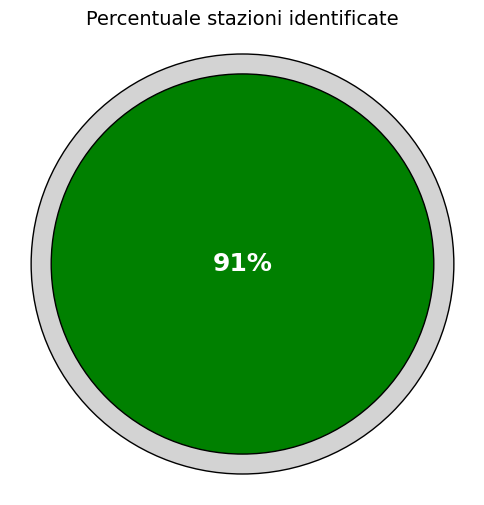

In [3]:
# Query per estrazione città e regione
query = "SELECT city, region FROM railway.station"

# Lettura da Postgres (SQL Alchemy + Pandas)
with engine.connect() as conn:
    df = pd.read_sql(query, conn)

# Trova le stazioni con la regione valorizzata
df["has_region"] = df["region"].notna() & (df["region"].str.strip() != "")
df["complete_info"] = df["has_region"]

# Definisci "Identificate" quelle con valori true e "Non identificate" quelle con valori false
summary = df["complete_info"].value_counts().rename(index={True: "Identificate", False: "Non identificate"}).reset_index()

# Imposta l'asse x con "Status" e l'asse y con "Count"
summary.columns = ["Status", "Count"]

# Dati dal dataframe 'summary'
identificate = summary.loc[summary["Status"] == "Identificate", "Count"].values[0]
non_identificate = summary.loc[summary["Status"] == "Non identificate", "Count"].values[0]
totale = identificate + non_identificate

# Percentuale identificate
perc_identificate = identificate / totale

# Crea la figura
fig, ax = plt.subplots(figsize=(6, 6))

# Cerchio esterno – totale (vuoto)
outer_circle = plt.Circle((0, 0), 1, color='lightgray', ec='black')

# Cerchio interno – proporzione identificate
inner_circle = plt.Circle((0, 0), perc_identificate, color='green', ec='black')

# Aggiunge i cerchi
ax.add_artist(outer_circle)
ax.add_artist(inner_circle)

# Testo al centro
ax.text(0, 0, f'{perc_identificate:.0%}', va='center', ha='center', fontsize=18, fontweight='bold', color='white')

# Rimuovi assi
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.1, 1.1)
ax.axis('off')

# Titolo
plt.title("Percentuale stazioni identificate", fontsize=14)

# Mostra il grafico
plt.show()

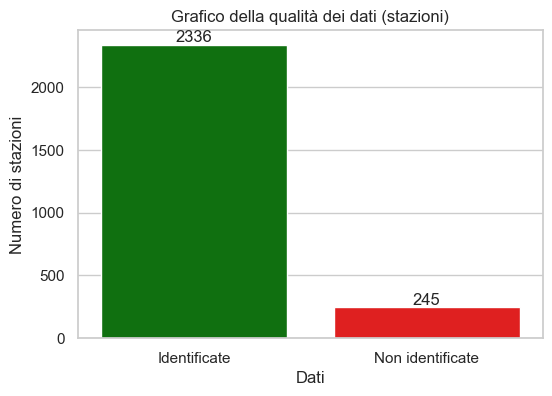

In [4]:
# Query per estrazione città e regione
query = "SELECT city, region FROM railway.station"

# Lettura da Postgres (SQL Alchemy + Pandas)
with engine.connect() as conn:
    df = pd.read_sql(query, conn)

# Trova le stazioni con la regione valorizzata
df["has_region"] = df["region"].notna() & (df["region"].str.strip() != "")
df["complete_info"] = df["has_region"]

# Definisci "Identificate" quelle con valori true e "Non identificate" quelle con valori false
summary = df["complete_info"].value_counts().rename(index={True: "Identificate", False: "Non identificate"}).reset_index()

# Imposta l'asse x con "Status" e l'asse y con "Count"
summary.columns = ["Status", "Count"]

# Imposta il grafico con tema bianco
sns.set(style="whitegrid")

# Imposta il size del grafico
plt.figure(figsize=(6, 4))

# Imposta i dati e associa i colori (verde -> Identificati, rosso -> Non identificati)
ax = sns.barplot(
    x="Status", 
    y="Count", 
    data=summary, 
    hue="Status",
    palette={"Identificate": "green", "Non identificate": "red"}, 
    legend=False
)

# Imposta il titolo
ax.set_title("Grafico della qualità dei dati (stazioni)")

# Titolo asse y
ax.set_ylabel("Numero di stazioni")

# Titolo asse x
ax.set_xlabel("Dati")

# Impostale in basso centrate alla barra
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom')

# Stampa il grafico
plt.show()

<h3>Distrubuzione delle stazioni su base regionale</h3>

<h3>Distrubuzione stazioni nel territorio italiano</h3>

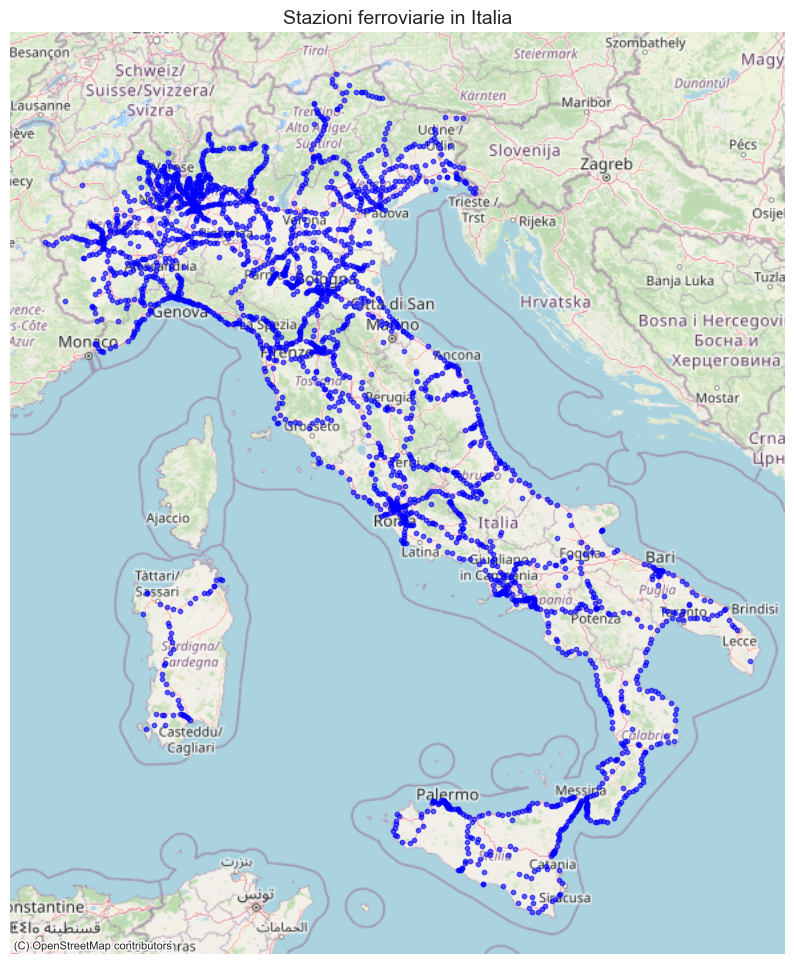

In [5]:
# Query per stazioni con coordinate valide
query = """
SELECT latitude, longitude
FROM railway.station
WHERE latitude IS NOT NULL AND longitude IS NOT NULL
"""

# Leggi i dati
with engine.connect() as conn:
    df = pd.read_sql(query, conn)

gdf = gpd.GeoDataFrame(df,
    geometry=gpd.points_from_xy(df.longitude, df.latitude),
    crs="EPSG:4326"
)

# Converti CRS per contextily (mercatore)
gdf = gdf.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(10, 12))
gdf.plot(ax=ax, markersize=10, color="blue", alpha=0.6)

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()
plt.title("Stazioni ferroviarie in Italia", fontsize=14)
plt.show()

<h3>Ritardo medio arrivo per regione</h3>

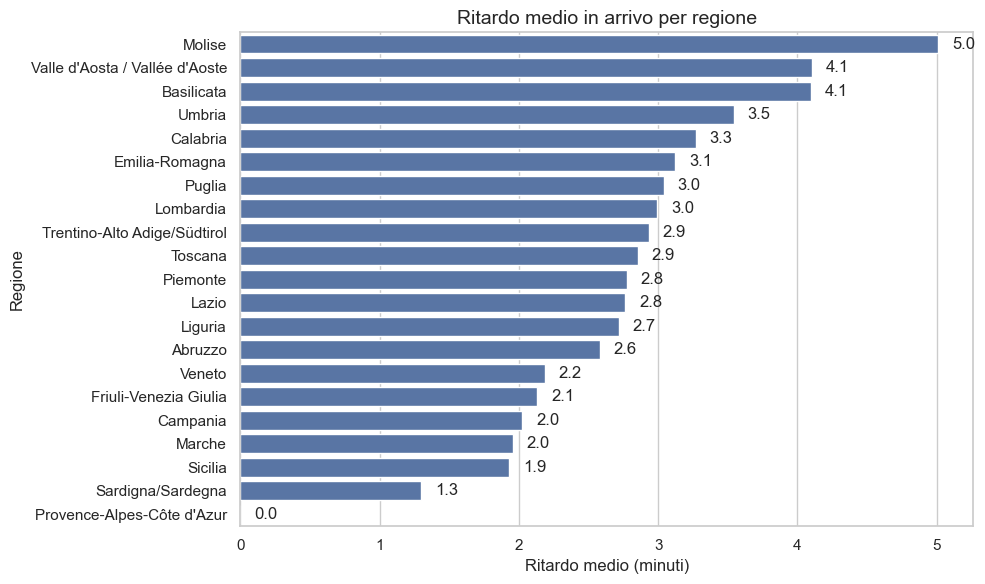

In [6]:
# Query per estrazione città e regione
query = """SELECT tt.station_id AS station_id, 
                  st.region AS region, 
                  COALESCE(tt.arrival_delay, 0) AS arrival_delay 
             FROM railway.timetable AS tt 
             JOIN railway.station AS st ON tt.station_id = st.id 
            WHERE tt.deleted = false
              AND st.region <> '' 
              AND tt.arrival_datetime < tt.departure_datetime 
              AND ABS(tt.arrival_delay - tt.departure_delay) < 10000 """

# Lettura da Postgres (SQL Alchemy + Pandas)
with engine.connect() as conn:
    df = pd.read_sql(query, conn)

df_avg_region = df.groupby('region')['arrival_delay'].mean().reset_index()

# Ordina i dati per ritardo medio decrescente
df_avg_region = df_avg_region.sort_values(by='arrival_delay', ascending=False)

# Imposta lo stile
sns.set(style="whitegrid")

# Dimensione del grafico
plt.figure(figsize=(10, 6))

# Grafico a barre orizzontali
ax = sns.barplot(
    data=df_avg_region,
    y='region',
    x='arrival_delay'
)

# Titolo e label assi
ax.set_title("Ritardo medio in arrivo per regione", fontsize=14)
ax.set_xlabel("Ritardo medio (minuti)")
ax.set_ylabel("Regione")

# Aggiungi le etichette dei valori alla fine di ogni barra
for i in ax.patches:
    ax.text(i.get_width() + 0.1, i.get_y() + i.get_height()/2,
            f"{i.get_width():.1f}", va='center')

# Mostra il grafico
plt.tight_layout()
plt.show()

<h3>Ritardo medio partenze per regione</h3>

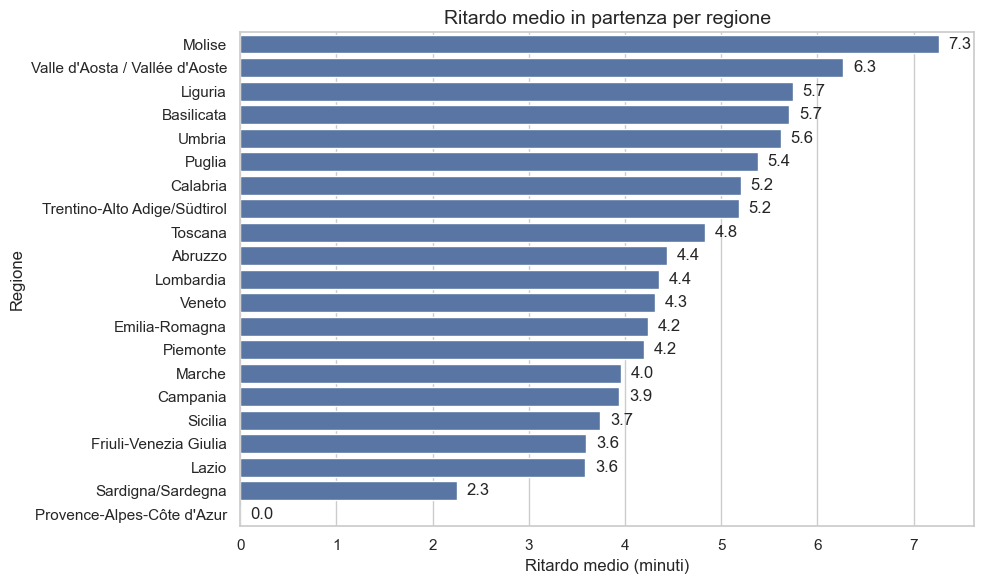

In [7]:
# Query per estrazione città e regione
query = """SELECT tt.station_id AS station_id, 
                  st.region AS region, 
                  COALESCE(tt.departure_delay, 0) AS departure_delay 
             FROM railway.timetable AS tt 
             JOIN railway.station AS st ON tt.station_id = st.id 
            WHERE tt.deleted = false
              AND st.region <> ''
              AND ABS(tt.arrival_delay - tt.departure_delay) < 10000 """

# Lettura da Postgres (SQL Alchemy + Pandas)
with engine.connect() as conn:
    df = pd.read_sql(query, conn)

df_avg_region = df.groupby('region')['departure_delay'].mean().reset_index()

# Ordina i dati per ritardo medio decrescente
df_avg_region = df_avg_region.sort_values(by='departure_delay', ascending=False)

# Imposta lo stile
sns.set(style="whitegrid")

# Dimensione del grafico
plt.figure(figsize=(10, 6))

# Grafico a barre orizzontali
ax = sns.barplot(
    data=df_avg_region,
    y='region',
    x='departure_delay'
)

# Titolo e label assi
ax.set_title("Ritardo medio in partenza per regione", fontsize=14)
ax.set_xlabel("Ritardo medio (minuti)")
ax.set_ylabel("Regione")

# Aggiungi le etichette dei valori alla fine di ogni barra
for i in ax.patches:
    ax.text(i.get_width() + 0.1, i.get_y() + i.get_height()/2,
            f"{i.get_width():.1f}", va='center')

# Mostra il grafico
plt.tight_layout()
plt.show()

<h3>Giornate con più cancellazioni</h3>

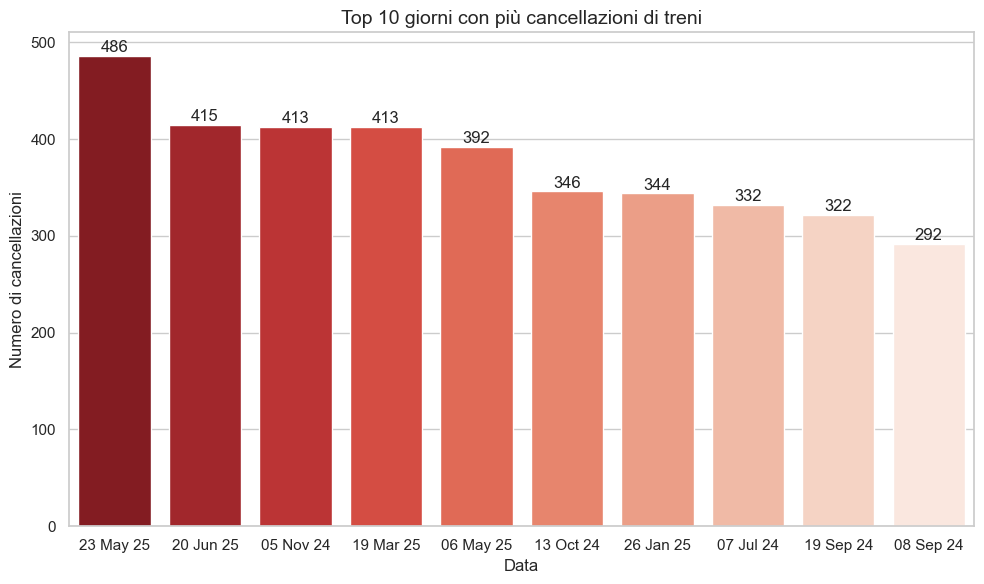

In [22]:
# Query per estrazione giorno e id treno
query = """SELECT DISTINCT day_number, train_id
             FROM railway.timetable
            WHERE deleted = true"""

# Lettura da Postgres (SQL Alchemy + Pandas)
with engine.connect() as conn:
    df = pd.read_sql(query, conn)

# Step 1: Data di riferimento
base_date = pd.to_datetime("2024-07-01")

# Step 2: Rinomina colonna
df_delete_count_byday = df.groupby('day_number').count().reset_index()
df_delete_count_byday = df_delete_count_byday.rename(columns={'train_id': 'cancellations'})

# Step 3: Aggiunge la data reale
df_delete_count_byday['date'] = base_date + pd.to_timedelta(df_delete_count_byday['day_number'], unit='D')

# Step 4: Prende i top 10 giorni con più cancellazioni
df_top10 = df_delete_count_byday.sort_values(by='cancellations', ascending=False).head(10)

# Step 5: Formatta la data come stringa breve per il grafico
df_top10['date_str'] = df_top10['date'].dt.strftime('%d %b %y')

# Genera una palette "Reds" invertita
palette = sns.color_palette("Reds", n_colors=len(df_top10))[::-1]

# Ordina df_top10 per data_str (così la palette si applica correttamente)
df_top10 = df_top10.sort_values(by='cancellations', ascending=False)

# Step 6: Crea il grafico
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=df_top10,
    x='date_str',
    y='cancellations',
    hue='date_str',
    palette=palette,
    dodge=False
)

# Titoli e etichette
ax.set_title("Top 10 giorni con più cancellazioni di treni", fontsize=14)
ax.set_xlabel("Data")
ax.set_ylabel("Numero di cancellazioni")

# Valori sopra le barre
for bar in ax.patches:
    ax.text(bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 0.5,
            f"{int(bar.get_height())}",
            ha='center', va='bottom')

plt.tight_layout()
plt.show()

<h3>Giornate con ritardi maggiori</h3>

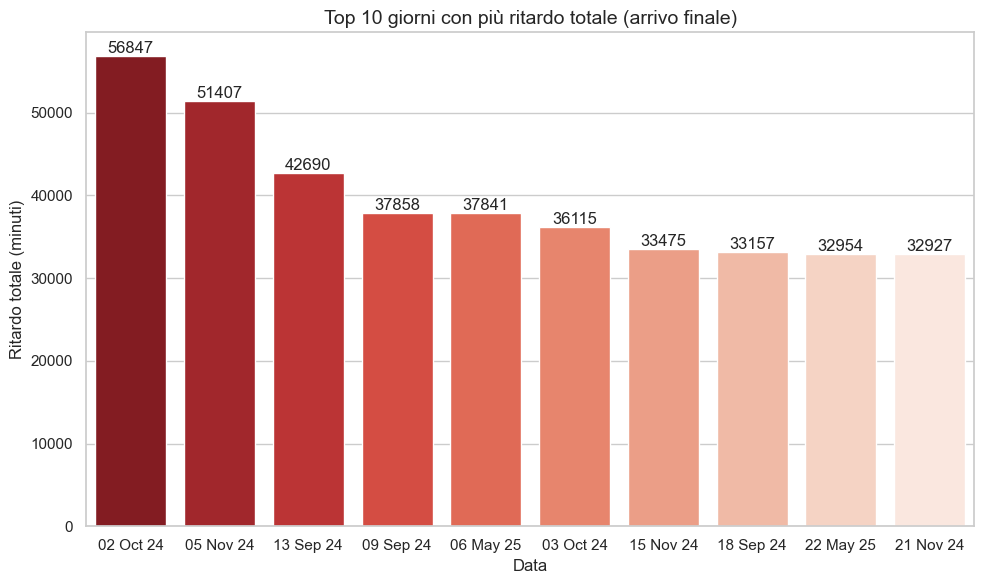

In [8]:
# Query per estrazione giorno, id treno, numero fermata e ritardo arrivi (esclude dati errati)
query = """SELECT day_number, train_id, stop_number, arrival_delay
             FROM railway.timetable
            WHERE deleted = false
            AND ABS(arrival_delay - departure_delay) < 10000 """

# Lettura da Postgres (SQL Alchemy + Pandas)
with engine.connect() as conn:
    df = pd.read_sql(query, conn)

# Data di riferimento (inizio raccolta dati)
base_date = pd.to_datetime("2024-07-01")

# Trovo la fermata finale di ogni treno (stop_number massimo)
df_last_stops = df.sort_values('stop_number').groupby(['day_number', 'train_id']).tail(1)

# Calcolo ritardo totale per ogni giorno
df_delay_by_day = df_last_stops.groupby('day_number')['arrival_delay'].sum().reset_index()
df_delay_by_day = df_delay_by_day.rename(columns={'arrival_delay': 'total_arrival_delay'})

# Aggiungo la data reale
df_delay_by_day['date'] = base_date + pd.to_timedelta(df_delay_by_day['day_number'], unit='D')

# Prendo i top 10 giorni con più ritardo totale
df_top10_delay = df_delay_by_day.sort_values(by='total_arrival_delay', ascending=False).head(10)

# Formatta per il grafico
df_top10_delay['date_str'] = df_top10_delay['date'].dt.strftime('%d %b %y')

# Palette rossa invertita
palette = sns.color_palette("Reds", n_colors=len(df_top10_delay))[::-1]

# Ordina correttamente
df_top10_delay = df_top10_delay.sort_values(by='total_arrival_delay', ascending=False)

# Creo il grafico
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=df_top10_delay,
    x='date_str',
    y='total_arrival_delay',
    hue='date_str',
    palette=palette
)

# Titoli e label assi
ax.set_title("Top 10 giorni con più ritardo totale", fontsize=14)
ax.set_xlabel("Data")
ax.set_ylabel("Ritardo totale (minuti)")

# Etichette sulle barre
for bar in ax.patches:
    ax.text(bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 5,
            f"{int(bar.get_height())}",
            ha='center', va='bottom')

# Stampo il grafico
plt.tight_layout()
plt.show()

<h3>Trend andamento ritardo nel tempo</h3>

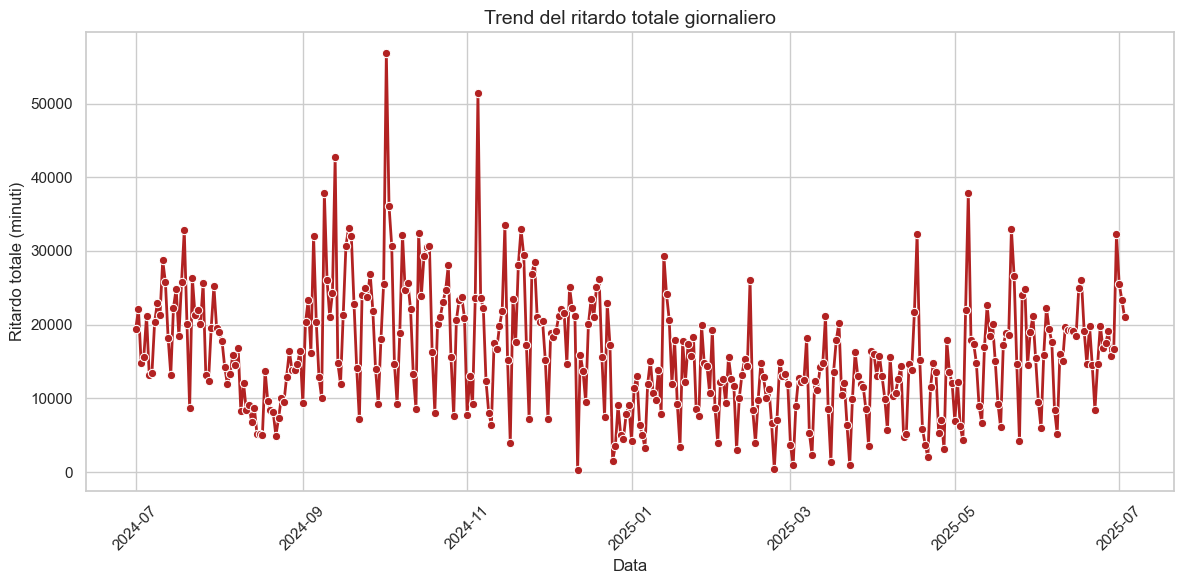

In [5]:
# Query per estrazione città e regione
query = """SELECT day_number, train_id, stop_number, arrival_delay
             FROM railway.timetable
            WHERE deleted = false
            AND ABS(arrival_delay - departure_delay) < 10000 """

# Lettura da Postgres (SQL Alchemy + Pandas)
with engine.connect() as conn:
    df = pd.read_sql(query, conn)

# Step 1: Data di riferimento
base_date = pd.to_datetime("2024-07-01")

# Trova la fermata finale di ogni treno (stop_number massimo)
df_last_stops = df.sort_values('stop_number').groupby(['day_number', 'train_id']).tail(1)

# Calcola ritardo TOTALE per ogni giorno
df_delay_by_day = df_last_stops.groupby('day_number')['arrival_delay'].sum().reset_index()
df_delay_by_day = df_delay_by_day.rename(columns={'arrival_delay': 'total_arrival_delay'})

# Aggiunge la data reale
df_delay_by_day['date'] = base_date + pd.to_timedelta(df_delay_by_day['day_number'], unit='D')

# Ordina per data (importante per il grafico a linee)
df_delay_by_day = df_delay_by_day.sort_values(by='date')

# Imposta stile
sns.set(style="whitegrid")

# Crea il grafico a linee
plt.figure(figsize=(12, 6))
ax = sns.lineplot(
    data=df_delay_by_day,
    x='date',
    y='total_arrival_delay',
    marker='o',
    linewidth=2,
    color='firebrick'
)

# Titoli e label
ax.set_title("Trend del ritardo totale giornaliero", fontsize=14)
ax.set_xlabel("Data")
ax.set_ylabel("Ritardo totale (minuti)")

# Migliora formattazione date
plt.tight_layout()
plt.show()

<h3>Tratte con maggior ritardo medio</h3>

C:\Users\andrea.spolaor\AppData\Local\Temp\ipykernel_27624\99411158.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


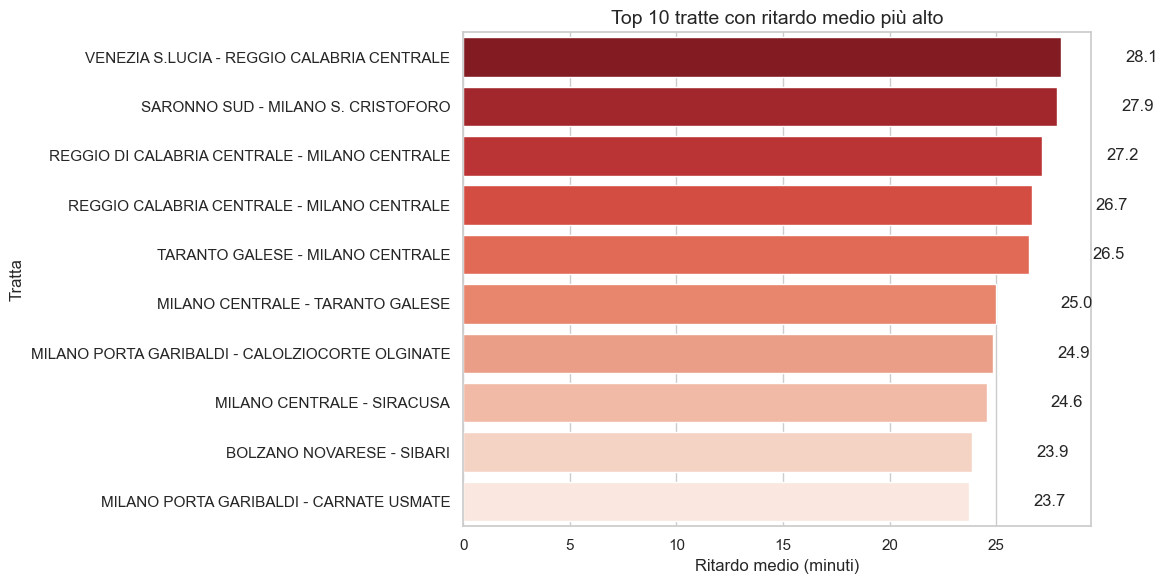

In [5]:
# Lettura dati dal db Postgres
query = """
    SELECT tt.day_number, tt.train_id, tt.stop_number, tt.arrival_delay, s.alias
      FROM railway.timetable AS tt
      JOIN railway.station AS s ON tt.station_id = s.id
     WHERE tt.deleted = false
       AND ABS(tt.arrival_delay - tt.departure_delay) < 10000
"""

# Esecuzione della query
with engine.connect() as conn:
    df = pd.read_sql(query, conn)

# Estraggo il primo elemento dell'alias (json array)
df['alias_clean'] = df['alias'].apply(lambda x: json.loads(x)[0] if pd.notna(x) else None)

# Seleziona prima e ultima stazione per ogni treno
df_first = df.sort_values('stop_number').groupby(['day_number', 'train_id']).first().reset_index()
df_last  = df.sort_values('stop_number').groupby(['day_number', 'train_id']).last().reset_index()

# Crea tratta concatenando primo e ultimo alias
df_route = pd.merge(df_first[['day_number', 'train_id', 'alias_clean']], 
                    df_last[['day_number', 'train_id', 'alias_clean', 'arrival_delay']],
                    on=['day_number', 'train_id'], 
                    suffixes=('_from', '_to'))

# Crea colonna 'route'
df_route['route'] = df_route['alias_clean_from'] + ' - ' + df_route['alias_clean_to']

# Calcola ritardo medio e numero di corse per tratta
df_stats_by_route = df_route.groupby('route').agg(
    avg_arrival_delay=('arrival_delay', 'mean'),
    num_trips=('arrival_delay', 'count')
).reset_index()

# Filtra solo le tratte con almeno 100 corse
df_stats_by_route = df_stats_by_route[df_stats_by_route['num_trips'] >= 100]

# Prendi le top 10 per ritardo medio
df_top10_routes = df_stats_by_route.sort_values(by='avg_arrival_delay', ascending=False).head(10)

# Palette rossa invertita (da rosso intenso a rosso meno intenso)
palette = sns.color_palette("Reds", n_colors=len(df_top10_routes))[::-1]

# Costruzione grafico
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")
ax = sns.barplot(
    data=df_top10_routes,
    x='avg_arrival_delay',
    y='route',
    palette= palette
)

# Imposto titolo e lable
ax.set_title("Top 10 tratte con ritardo medio più alto", fontsize=14)
ax.set_xlabel("Ritardo medio (minuti)")
ax.set_ylabel("Tratta")

# Imposto etichette sui valori
for bar in ax.patches:
    ax.text(bar.get_width() + 3, bar.get_y() + bar.get_height() / 2,
            f"{bar.get_width():.1f}", va='center')

# Stampo il grafico
plt.tight_layout()
plt.show()